In [41]:
from datetime import datetime, timedelta
import numpy as np
import pandas as pd
import json
import os
import math
import heapq
import seaborn as sns
import matplotlib.pyplot as plt
import csv

import random

In [42]:
cwd = os.getcwd()
print(cwd)

/Users/m1m1024/Desktop/cs330/cs330-casestudy


# Load Data

In [43]:
with open(f'{cwd}/adjacency 2.json') as adjacency_f:
    adjacency = json.load(adjacency_f)
    
with open(f'{cwd}/node_data.json') as node_f:
    nodes = json.load(node_f)

#nodes_df = pd.DataFrame(nodes).T

# Functions

In [44]:
def haversine_distance(lat1, lon1, lat2, lon2):
    '''
    Haversine distance metric between two points
    '''
    
    #earth radius in km
    radius = 6371.0

    #convert lat lon into radians from degress
    lat1 = math.radians(lat1)
    lon1 = math.radians(lon1)
    lat2 = math.radians(lat2)
    lon2 = math.radians(lon2)

    #haversine from wikipedia
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = math.sin(dlat / 2)**2 + math.cos(lat1) * math.cos(lat2) * math.sin(dlon / 2)**2
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))
    distance = radius * c

    return distance

In [65]:
GRID_SIZE = 0.05  # arbitrarily defined this grid size, not sure if we want to fix it


def get_grid_cell(lat, lon):
    return math.floor(lat / GRID_SIZE), math.floor(lon / GRID_SIZE)


grid_index = {}
for node_id, node_info in nodes.items():
    node_lat, node_lon = node_info['lat'], node_info['lon']
    grid_cell = get_grid_cell(node_lat, node_lon)
    if grid_cell not in grid_index:
        grid_index[grid_cell] = []
    grid_index[grid_cell].append(node_id)

In [66]:
# def get_nearest_node(lat, lon):
#     '''
#     Find nearest node via Haversine distance
#     TODO: Find more efficient nearest node method, how account for time if very far from nearest node?
#     '''
#     min_dist = float('inf')
#     nearest_node = ''
#     for node in nodes:
#         dist = haversine_distance(nodes[node]['lat'], nodes[node]['lon'], lat, lon)
#         if dist < min_dist:
#             min_dist = dist
#             nearest_node = node
#     return nearest_node

def get_nearest_node(lat, lon):
    target_cell = get_grid_cell(lat, lon)
    min_dist = float('inf')
    nearest_node = None

    # Search within the target cell and adjacent cells
    for dx in range (-2, 3):
        for dy in range (-2, 3):
            cell = (target_cell[0] + dx, target_cell[1] + dy)
            if cell in grid_index:
                for node_id in grid_index[cell]:
                    dist = haversine_distance(nodes[node_id]['lat'], nodes[node_id]['lon'], lat, lon)
                    if dist < min_dist:
                        min_dist = dist
                        nearest_node = node_id

    return nearest_node

In [47]:
def get_datetime(time_string):
    '''
    Convert any datetime strings to datetime
    '''
    datetime_format = "%m/%d/%Y %H:%M:%S"
    time = datetime.strptime(time_string, datetime_format)
    return time

In [48]:
def djikstras(source, dest, dt, day_type, start_time):
    '''
    Djikstra's algorithm
    Returns: dict of minimum distances to nodes and dict of node parents
    '''
    distance = {} #distances to each node
    parent = {} #
   # print("datetime ", dt)
    hour = dt.hour
#     print("source ", source)
#     print("dest ", dest)
 
    
    #initialize all distances to infinity
    for node in nodes:
        distance[node] = float('inf')
    distance[source] = 0
    pq = [(0, source)]
    while pq:
        node_dist, node = heapq.heappop(pq)
        if node == dest: #early stopping
            break
        if node in adjacency:
            for neighbor in adjacency[node]:
                for edge in adjacency[node][neighbor]:
                    if edge['hour'] == hour and edge['day_type'] == day_type:
                        edge_dist = edge['time']
                        if distance[neighbor] > node_dist + edge_dist:
                            #print("edge dist ", edge_dist)
                           # print("node dist ", node_dist)
                            distance[neighbor] = node_dist + edge_dist
                           # print(distance[neighbor])
                            parent[neighbor] = node
                            heapq.heappush(pq, (distance[neighbor], neighbor))
    return distance, parent

In [49]:
def get_path(parent, source_node, dest_node):
    '''
    Recover path using list of node parents, start at destination and end at source
    Returns: list of nodes in path (reverse order)
    '''
    path = [dest_node]
    current_node = dest_node
    while current_node != source_node:
        path.append(parent[current_node])
        current_node = parent[current_node]
    return path

In [50]:
def get_driver(p, dt, day_type, start_time):
    '''
    Get the next driver from the driver PQ (Task 1 based on time)
    Update relevant driver and passenger variables and get the time to traverse from driver location to passenger pickup
    Returns: Driver match
    '''
    p.total_time = 0
    if driver_q:
        available_time, idx, d = heapq.heappop(driver_q) #(datetime, id, driver object)
    else:
        return None
    #print(idx)
    wait_time = 0
    if p.appear < available_time:
        time_diff = available_time - p.appear
        wait_time += time_diff.seconds/3600 #get number of hours passenger has to wait for next driver to be available
    time, _ = djikstras(d.current_node, p.source_node, dt, day_type, start_time)
    wait_time += time[p.source_node]
    d.current_node = p.source_node
    d.pickup_time += wait_time
    p.total_time += wait_time
    return d

In [51]:
# def check_active(current_time, d):
#     #max_active_time = timedelta(hours=8) #check if driver has been active for over 8 hours, reference passenger appear for current time
#     #time_active = current_time - d.appear
#     #if time_active < max_active_time:
#     driver_leaves = 0.8
#     if random.random() < driver_leaves:
#         return True #still active
#     else:
#         return False #driver is inactive
def check_active(current_time, d):
    max_active_time = timedelta(hours=8) #check if driver has been active for over 8 hours, reference passenger appear for current time
    time_active = current_time - d.appear
    probability = 0.0

    if time_active >= max_active_time:
        probability = 1.0

    # Calculate probability based on hours active
    else:
        hours_active = time_active.total_seconds() / 3600  # Convert to hours
        probability = hours_active / 8
    
    if random.random() < probability:
        return False
    else:
        return True

In [52]:
def ride():
    '''
    Main function for going through passenger and driver queues
    '''
    active_drivers = []
    completed_passengers = []
    completed_drivers = []
    passenger_times = []
    driver_profits = []
    day_type = 'weekday'
    start_time = passenger_q[0][0]
    current_time = start_time
    passenger_index = 0  # Track the passenger queue index
    
    
    while passenger_index < len(passenger_q):
        _, _, p = passenger_q[passenger_index]  #(datetime, id, passenger object)
        d = get_driver(p, current_time, day_type, start_time)
        if d is None:
            break
        active_drivers.append(d) #driver is now active (SHOULD CHANGE TO STATUS VARIABLE ASSOCIATED WITH DRIVER CLASS?)
        time, parent = djikstras(p.source_node, p.dest_node, current_time, day_type, start_time)
        ride_time = time[p.dest_node]
        #print('ridetime',ride_time)
        p.total_time += ride_time
       # print('totaltime',p.total_time)
        completed_passengers.append(p)
        passenger_times.append(p.total_time)
        d.source_node = p.dest_node
        d.source = p.dest
        d.ride_time += ride_time
        if math.isfinite(p.total_time):
            current_time = timedelta(hours=p.total_time) + p.appear  #get current time using total time waiting + riding by passenger
        passenger_index += 1
        if check_active(current_time, d):
            heapq.heappush(driver_q, (current_time, d.idx, d))
            #TODO: TASK 2 CONCERN -> how to deal with case where driver is not available yet but passenger request ride and is nearest
       
        else:
            completed_drivers.append(d)
            driver_profits.append(d.get_profit())
    
    while driver_q:
        _, _, d = heapq.heappop(driver_q)
        completed_drivers.append(d)
        driver_profits.append(d.get_profit())
        
    return completed_passengers, completed_drivers, passenger_times, driver_profits

# Classes (Driver, Passenger)

In [53]:
class driver:
    def __init__(self, index, appear, source_lat, source_lon):
        self.idx = index
        self.appear = get_datetime(appear)
        self.source = (source_lat, source_lon)
        self.ride_time = 0 #total time logged driving passengers
        self.pickup_time = 0 #total time logged driving to passengers
        self.source_node = get_nearest_node(self.source[0], self.source[1])
        self.current_node = self.source_node #update as performing routes

    def get_profit(self):
        self.profit = self.ride_time - self.pickup_time
        return self.profit

In [67]:
class passenger:
    def __init__(self, index, appear, source_lat, source_lon, dest_lat, dest_lon):
        self.idx = index
        self.appear = get_datetime(appear)
        self.source = (source_lat, source_lon)
        self.dest = (dest_lat, dest_lon)
        self.total_time = 0 #total time logged for passenger (time appear to time drop off)
        self.source_node = get_nearest_node(self.source[0], self.source[1])
        self.dest_node = get_nearest_node(self.dest[0], self.dest[1])

# Run Task 1

In [68]:
passenger_q = []

with open(f'{cwd}/passengers.csv', 'r') as csvfile:
    reader_variable = csv.reader(csvfile, delimiter=",")
    first_line = csvfile.readline()
    for index, row in enumerate(reader_variable):
        p = passenger(index, row[0], float(row[1]), float(row[2]), float(row[3]), float(row[4]))
        passenger_q.append((p.appear, p.idx, p))

In [69]:
def check_for_none(file_path):
    with open(file_path, 'r') as file:
        lines = file.readlines()

    none_lines = []
    for line_num, line in enumerate(lines, start=1):
        if "None" in line:
            none_lines.append(f"Found 'None' on line {line_num}: {line.strip()}")

    return none_lines


In [70]:
file_path = 'passenger_sanity_check.txt'

with open(file_path, 'w') as file:
    for passenger in passenger_q:
        file.write('start: '+str(passenger[2].source_node) +'   dest: '+ str(passenger[2].dest_node) + '\n')


result = check_for_none(file_path)
if result:
    print("Lines containing 'None':")
    for line in result:
        print(line)
else:
    print("No lines containing 'None' found.")


Lines containing 'None':
Found 'None' on line 155: start: 42430271   dest: None
Found 'None' on line 339: start: None   dest: 42436129
Found 'None' on line 449: start: None   dest: 1061531777
Found 'None' on line 598: start: 42432444   dest: None
Found 'None' on line 620: start: 42435472   dest: None
Found 'None' on line 837: start: 482671978   dest: None
Found 'None' on line 868: start: 42457476   dest: None
Found 'None' on line 923: start: None   dest: 42440737
Found 'None' on line 1064: start: 42422050   dest: None
Found 'None' on line 1435: start: 1773076513   dest: None
Found 'None' on line 1453: start: 42442870   dest: None
Found 'None' on line 1515: start: 42430643   dest: None
Found 'None' on line 2221: start: 427841062   dest: None
Found 'None' on line 2283: start: 42452598   dest: None
Found 'None' on line 2471: start: None   dest: 42438498
Found 'None' on line 2491: start: None   dest: 42422592
Found 'None' on line 2523: start: None   dest: 42528617
Found 'None' on line 2552

In [39]:
driver_q = []

with open(f'{cwd}/drivers.csv', 'r') as csvfile:
    reader_variable = csv.reader(csvfile, delimiter=",")
    first_line = csvfile.readline()
    for index, row in enumerate(reader_variable):
        d = driver(index, row[0], float(row[1]), float(row[2]))
        driver_q.append((d.appear, d.idx, d))
        
heapq.heapify(driver_q)

In [23]:
completed_passengers, completed_drivers, passenger_times, driver_profits = ride()

KeyError: None

In [48]:
file_path = 'passenger_times.txt'

# Open the file in write mode
with open(file_path, 'w') as file:
    # Write each value in passenger_times list to the file
    for time in passenger_times:
        file.write(str(time) + '\n')

In [40]:
file_path = 'driver_profits.txt'

# Open the file in write mode
with open(file_path, 'w') as file:
    # Write each value in passenger_times list to the file
    for profit in driver_profits:
        file.write(str(profit) + '\n')

# Djikstra's Test
Single passenger and single driver

In [20]:
#test passenger
p1_test = passengers.iloc[0,:]
p1 = passenger(p1_test['Date/Time'], p1_test['Source Lat'], p1_test['Source Lon'], p1_test['Dest Lat'], p1_test['Dest Lon'])
print(vars(p1))

{'appear': datetime.datetime(2014, 4, 25, 0, 0), 'source': (40.6466, -73.7896), 'dest': (40.7603, -73.9794), 'total_time': 0, 'source_node': '599036657', 'dest_node': '42430361'}


In [21]:
#test driver
d1_test = drivers.iloc[0,:]
d1 = driver(d1_test['Date/Time'], d1_test['Source Lat'], d1_test['Source Lon'])
print(vars(d1))

{'appear': datetime.datetime(2014, 4, 25, 0, 14), 'source': (40.667, -73.8713), 'ride_time': 0, 'pickup_time': 0, 'source_node': '1942055181', 'current_node': '1942055181'}


https://docs.python.org/3/library/heapq.html
Heapq --> PQ implementation

https://builtin.com/software-engineering-perspectives/dijkstras-algorithm
Djikstras with heapq as PQ implementation

In [22]:
time, parent = djikstras(p1.source_node, p1.dest_node)
print('route time (hours):', time[p1.dest_node]) #get time from source to destination
path = get_path(parent, p1.source_node, p1.dest_node) #retrieve path from parent dict
path_coords = nodes_df[nodes_df.index.isin(path)] #retrieve path coordinates (to verify graphically)
print('path trajectory:')
print(path_coords.head(5))

route time (hours): 0.6220687313557267
path trajectory:
                  lon        lat
599140119  -73.797688  40.644869
280637036  -73.818879  40.707431
2799547029 -73.953619  40.741575
597311193  -73.928280  40.736499
455622434  -73.801249  40.667113


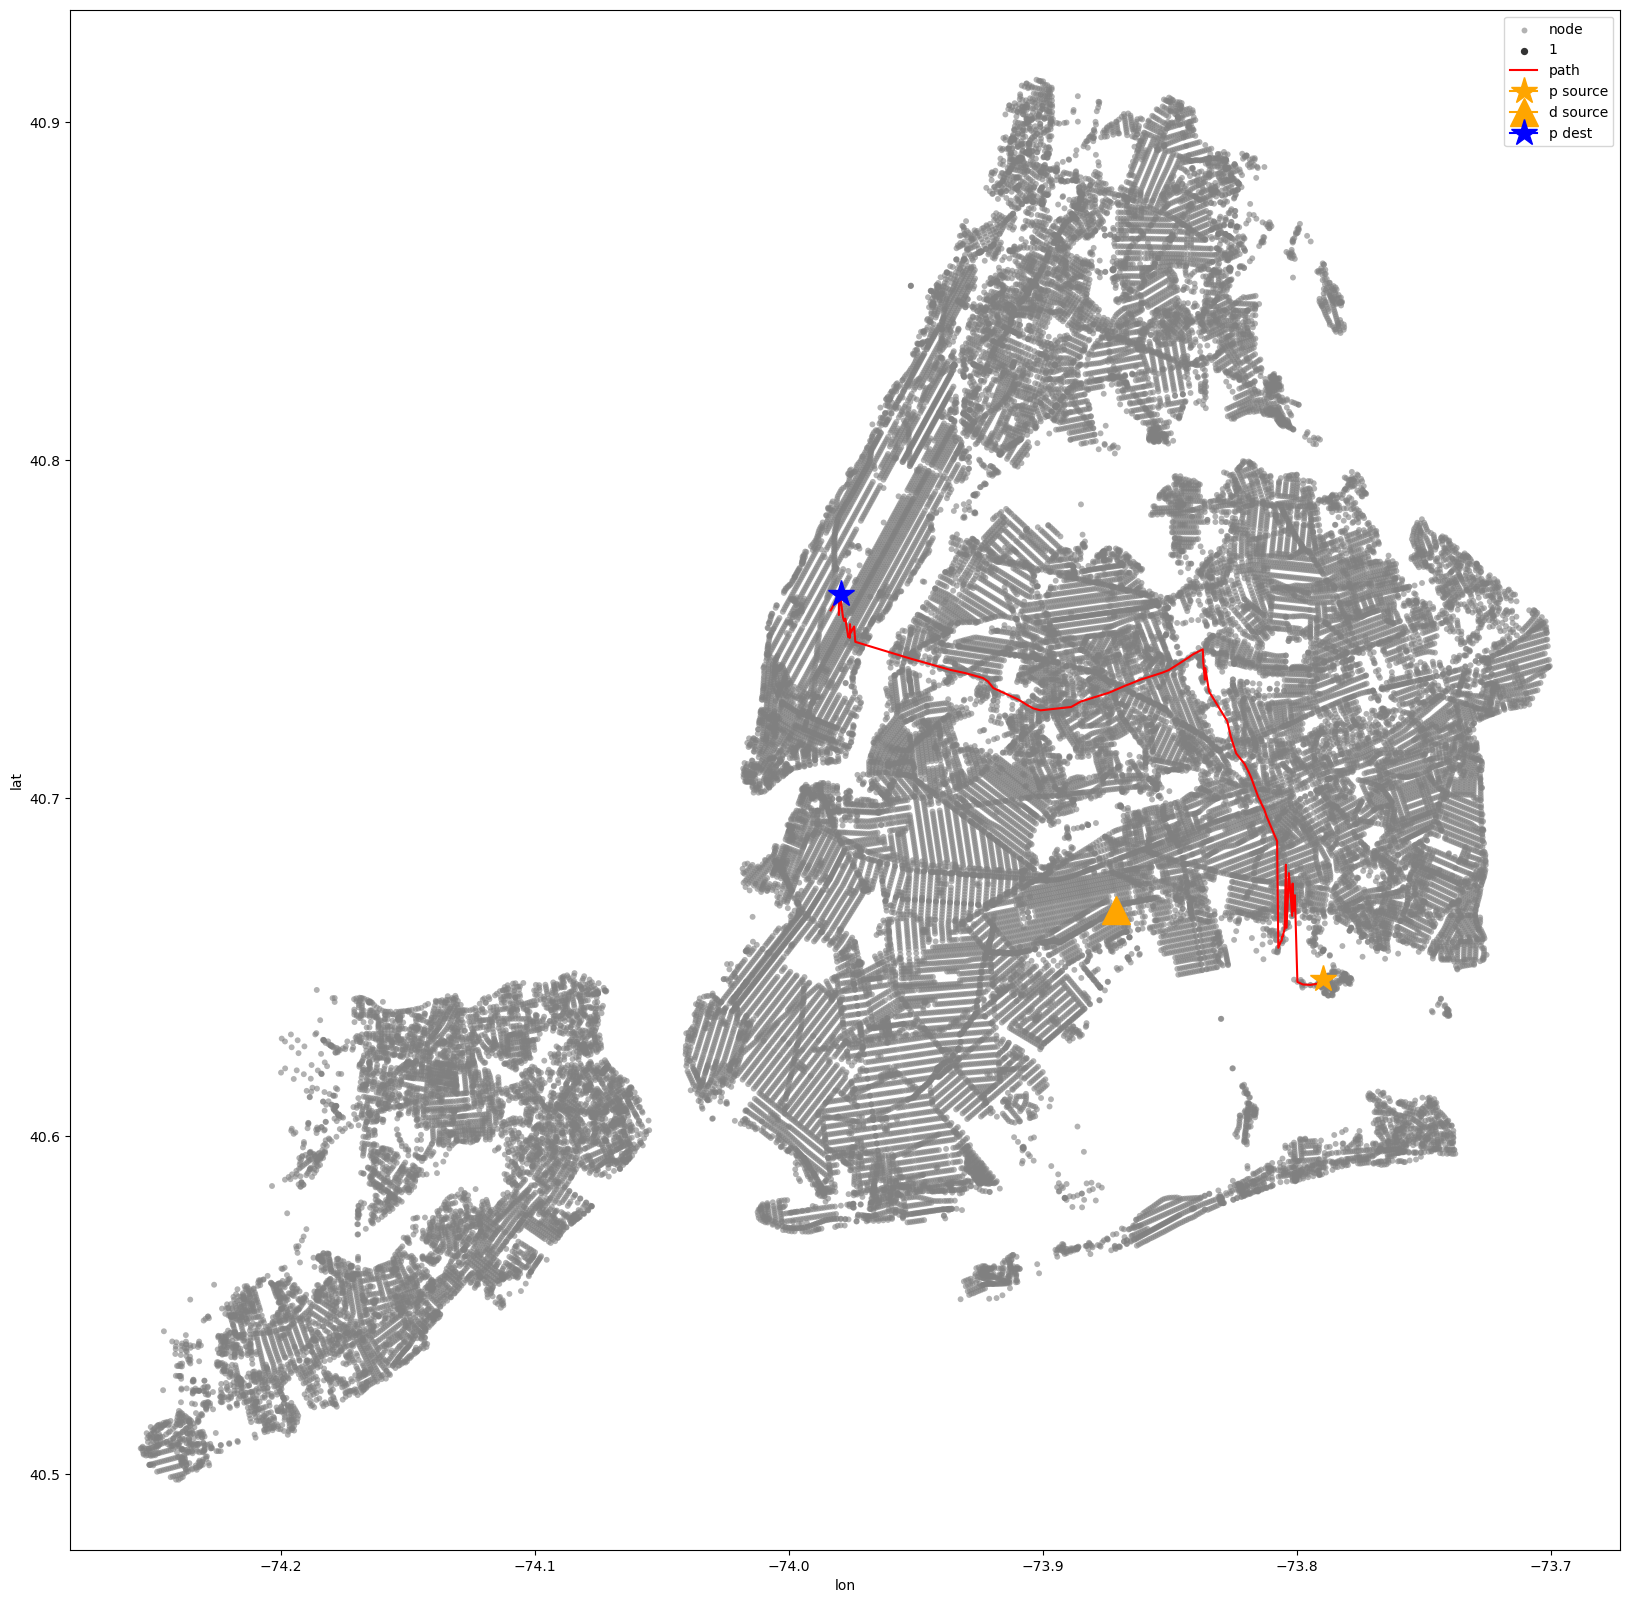

In [24]:
#plot nodes and path coords
plt.figure(figsize=(20, 20))
sns.scatterplot(nodes_df, x='lon', y='lat', size=1, alpha=0.6, linewidth=0, label='node', color='grey')
sns.lineplot(path_coords, x='lon', y='lat', color='red', alpha=1, label='path')
plt.plot([p1.source[1]], [p1.source[0]], marker='*', color='orange', markersize=20, label='p source')
plt.plot([d1.source[1]], [d1.source[0]], marker='^', color='orange', markersize=20, label='d source')
plt.plot([p1.dest[1]], [p1.dest[0]], marker='*', color='blue', markersize=20, label='p dest')
plt.legend()